In [105]:
# This is an example of how SASpy can be used within python to predict potential donors from US Census data.


# The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.



In [132]:
#Import necessary libraries for this project
import saspy
import pandas as pd
import numpy as np
from time import time
from IPython.display import display
from IPython.display import HTML

In [133]:
# starting the SAS session
sas = saspy.SASsession(cfgname='autogen_winlocal')

SAS Connection established. Subprocess id is 25576



In [134]:
#loading the census data.

#The foloowing method below display how to read a csv file using pandas and then reading in
#the data frome into a SAS object
#cen_data0_pd = pd.read_csv("C:\\Users\\negraj\\Documents\\Learning\\SAS and SASPy\\SASPy-Examples\\census.csv")
#cen_data0 = sas.df2sd(cen_data0_pd) # the short form of: hr = sas.dataframe2sasdata(hr_pd)

#You can also read in a dataset directly into a SAS object using the code below.
#cen_data0 = sas.read_csv("C:\\Users\\negraj\\Documents\\Learning\\SAS and SASPy\\SASPy-Examples\\census.csv", 'cenData', "Sasuser")
cen_data0 = sas.sasdata('cenData5', libref='Sasuser') # using this data set as there is a current issue with the read_csv function not 
#being able to handle - hyphen characters

In [135]:
#Display the first record to verify data was read in
#display(cen_data0_pd.head(n=1))
print("First value is:")
display(cen_data0.head(obs=1))

First value is:


,age,workclass,education_level,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K


In [136]:
#Data Exploration using SASpy
#display the amount of observations within your data
records = cen_data0.obs()

In [137]:
#Number of records where individuals income is more than $50,000
# I am first going to turn our SAS data object into a pandas data frame to utilize
#value counts. Using value counts allows me to count distnict values very easily
cen_data0_pd = cen_data0.to_df()

In [138]:
#Using value counts to count ditninct values in the data set. A quick print of the value displays the
# ditinct value and its count. The first value returned by value counts is values x <= 50K
# the second value is values x > 50K
greater_50k = cen_data0_pd['income'].value_counts()[1]
_50k_or_less = cen_data0_pd['income'].value_counts()[0]

In [113]:
# Determining the percent of individuals whose income is greater than 50k
greater_percent = (greater_50k/(greater_50k+_50k_or_less))*100

In [139]:
print("Total number of records: {}".format(records))
print("Individuals making more than $50,000: {}".format(greater_50k))
print("Individuals making at most $50,000: {}".format(_50k_or_less))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))


Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78439697492371%


In [115]:
#----------------------Part 2------------------------------
# Featureset Exploration
#Transforming Skewed continous features
#You need to use the content function to view the column number to then use it in the histogram function later

In [140]:
#drop income using pandads DataFrame
income_data = cen_data0_pd['income']
feature_data = cen_data0_pd.drop('income', axis=1)

In [141]:
#convert back to SAS data object
cen_data1_noIncome = sas.dataframe2sasdata(feature_data,'cenData_noIncome', "Sasuser")


In [118]:
display(cen_data1_noIncome.contents())

{'Attributes':                      Member               Label1                     cValue1  \
 0  SASUSER.CENDATA_NOINCOME        Data Set Name    SASUSER.CENDATA_NOINCOME   
 1  SASUSER.CENDATA_NOINCOME          Member Type                        DATA   
 2  SASUSER.CENDATA_NOINCOME               Engine                          V9   
 3  SASUSER.CENDATA_NOINCOME              Created         05/28/2019 13:21:26   
 4  SASUSER.CENDATA_NOINCOME        Last Modified         05/28/2019 13:21:26   
 5  SASUSER.CENDATA_NOINCOME           Protection                         NaN   
 6  SASUSER.CENDATA_NOINCOME        Data Set Type                         NaN   
 7  SASUSER.CENDATA_NOINCOME                Label                         NaN   
 8  SASUSER.CENDATA_NOINCOME  Data Representation                  WINDOWS_64   
 9  SASUSER.CENDATA_NOINCOME             Encoding  wlatin1  Western (Windows)   
 
         nValue1                Label2 cValue2  nValue2  
 0           NaN          Observati


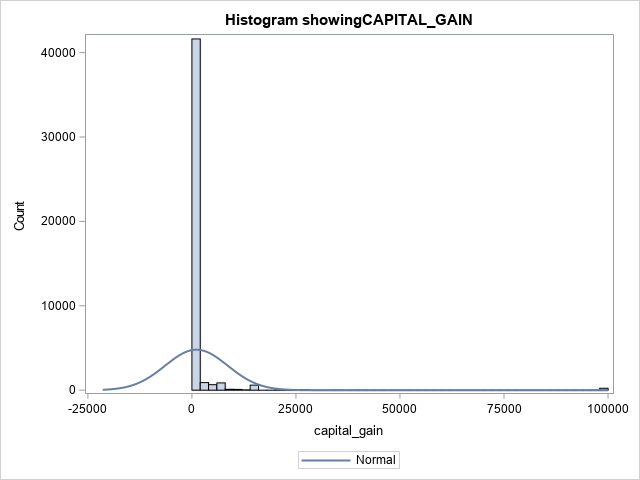


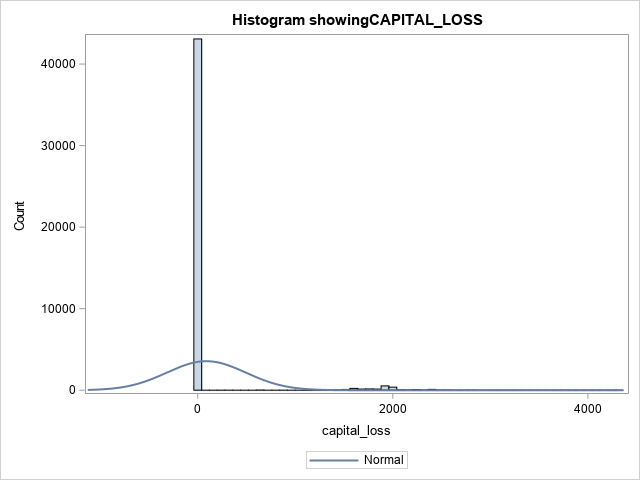

In [142]:
#diplay histogram for capital gains and capital loss 
for col in ['capital_gain','capital_loss']:
    cen_data1_noIncome.hist(col, title='Histogram showing'+col.upper())

In [120]:
#log based method
skewed_features = ['capital_gain','capital_loss']
#transform back to pandas dataframe 
cen_data1_pd = cen_data1_noIncome.to_df()

In [150]:
log_transformed_feat = pd.DataFrame(data = feature_data)
log_transformed_feat[skewed_features] = feature_data[skewed_features].apply(lambda x:np.log(x+1))
#changing back to SAS data object

cen_data_logTransform = sas.dataframe2sasdata(log_transformed_feat)


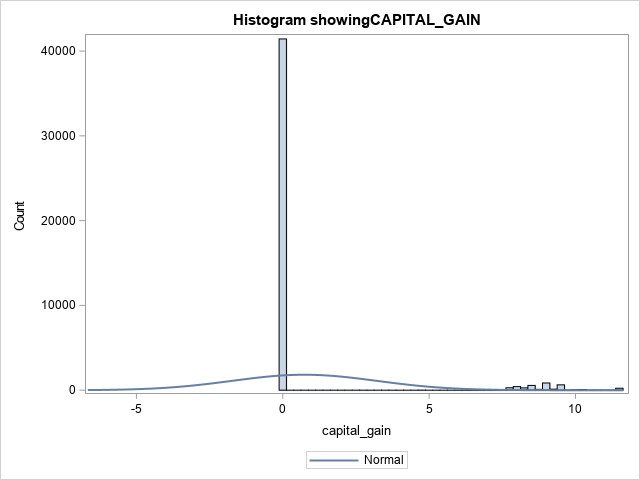


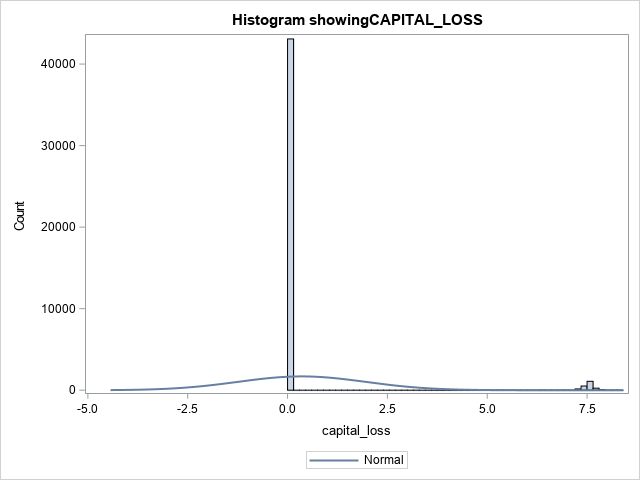

In [151]:
for col in ['capital_gain','capital_loss']:
    cen_data_logTransform.hist(col, title='Histogram showing'+col.upper())

In [152]:
#to use the proc univariate procedure you need to create a a python object that uses the SASUtil 
#library
util = sas.sasutil()

In [157]:
univariate_results = util.univariate(data=cen_data_logTransform, var= 'capital_gain capital_loss', histogram = 'VSCALE=PERCENT')

In [158]:
dir(univariate_results)

['ERROR_LOG']

In [159]:
univariate_results.ERROR_LOG